In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_cleaned.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_cleaned.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_lifetime_cumulative.tsv')
THE_NUMBERS_PATH_YEARLY = os.path.join(DATA_PATH, 'the_numbers_yearly_score.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Thriller, Crime Thriller, Action, Mystery"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...","Mystery, Horror, Children's/Family, Drama"


### 1.3 The numbers data yearly cumulated

In [6]:
df_numbers_cum=pd.read_csv(THE_NUMBERS_PATH, sep='\t').set_index('actor_name')

#drop all 0 rows
df_numbers_cum = df_numbers_cum.loc[~(df_numbers_cum==0).all(axis=1)]
df_numbers_cum.drop(['1978', '1979'], axis=1, inplace=True)
df_numbers_cum.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,min_year,min_year_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,539.0,539.0,539.0,539.0,539.0,602.0,602.0,602.0,602.0,...,696.0,696.0,696.0,755.0,755.0,755.0,755.0,755.0,1980,440.0
Clint Eastwood,360.0,360.0,446.0,540.0,707.0,789.0,872.0,872.0,944.0,972.0,...,1672.0,1672.0,1672.0,1743.0,1743.0,1743.0,1779.0,1779.0,1980,360.0


### 1.4 The numbers data yearly

In [7]:
df_numbers_yearly=pd.read_csv(THE_NUMBERS_PATH_YEARLY, sep='\t').set_index('actor_name')
df_numbers_yearly.reset_index(inplace=True)
df_numbers_yearly.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
0,Jane Fonda,440.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,...,4,5,5,5,5,6,6,6,6,6
1,Clint Eastwood,360.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,...,19,19,19,19,19,20,20,20,21,21


In [8]:
list_ranking = ['nb_ranked_{}'.format(x) for x in range(1980, 2023)]
df_numbers = pd.merge(df_numbers_cum, df_numbers_yearly.set_index('actor_name')[list_ranking], left_index=True, right_index=True)
df_numbers.head(5)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,440.0,539.0,539.0,539.0,539.0,539.0,602.0,602.0,602.0,602.0,...,4,5,5,5,5,6,6,6,6,6
Clint Eastwood,360.0,360.0,446.0,540.0,707.0,789.0,872.0,872.0,944.0,972.0,...,19,19,19,19,19,20,20,20,21,21
John Belushi,269.0,394.0,394.0,394.0,394.0,394.0,394.0,394.0,394.0,394.0,...,2,2,2,2,2,2,2,2,2,2
Burt Reynolds,262.0,262.0,262.0,262.0,262.0,262.0,262.0,262.0,262.0,262.0,...,2,2,2,2,2,2,2,2,2,2
Goldie Hawn,258.0,258.0,339.0,339.0,405.0,405.0,471.0,530.0,530.0,530.0,...,11,11,11,11,12,12,12,12,12,12


# 2.1 Df chars cleaning

In [9]:
# Keeps just one row if an actor played several roles in a movie
df_chars.drop_duplicates(['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [10]:
# Keeps only movies where we have at least two actors (as the interest is coacting)
df_chars = df_chars[df_chars.duplicated('wikipedia_m_ID', keep=False)]

In [11]:
# Keeps only characters from american movies
df_chars = df_chars.merge(df_movies[['wikipedia_m_ID']], how='inner', on='wikipedia_m_ID')

In [12]:
df_chars[df_chars['m_release_date'].dt.year < 1980]['actor_name'].unique()

array(['Ruth Chatterton', 'Fredric March', 'Florence Rice', ...,
       'Fred Groves', 'Duke R. Lee', 'Rich Little'], dtype=object)

In [13]:
df_chars['wikipedia_m_ID'].nunique()

25938

In [ ]:
df_tmp = df_chars.copy()
df_tmp['m_release_year'] = df_tmp['m_release_date'].dt.year
df_tmp = df_tmp.groupby('actor_name').agg({'m_release_year': ['min', 'max']})
df_tmp = df_tmp['m_release_year']
df_tmp = df_tmp.loc[(df_tmp['min']<1980) & (df_tmp['max']>1980)]
df_tmp.head()

In [ ]:
df_numbers.reset_index()[df_numbers.reset_index()['actor_name']=='Alan Arkin']

In [ ]:
df_e = pd.merge(df_tmp, df_chars_merged, left_index=True, right_on='actor_name', how='left')
df_e.head()

In [ ]:
df_numbers_yearly[columns]

In [ ]:
df_e.loc[(df_e['min_year_score'] > 0) & (df_e['min_year']>1980)]['actor_name'].unique()

In [ ]:
df_numbers.reset_index()[df_numbers.reset_index()['actor_name']=='Sean Connery']

In [ ]:
df_e[df_e['actor_name']=='Sean Connery'].sort_values('m_release_date')[['m_release_date', 'actor_score']]

In [ ]:
df_e.loc[(df_e['min_year_score'] > 0)]['actor_name'].nunique()

# 2.2 Df movies cleaning

In [14]:
# Keeps only movies where actors data is available
df_movies = df_movies.merge(df_chars.drop_duplicates('wikipedia_m_ID', keep='first'), how='inner', on='wikipedia_m_ID')

# 2.3 Compute number of actors per movie

In [15]:
#compute number of actors per movie
nb_actors_per_movie = df_chars['wikipedia_m_ID'].value_counts().reset_index().copy()
nb_actors_per_movie.rename({'wikipedia_m_ID': 'nb_actors', 'index': 'wikipedia_m_ID'}, axis=1, inplace=True)

In [16]:
#add nb of actors per movie
df_movies = df_movies.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()
df_chars = df_chars.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()

In [17]:
#movies with just 1 actor are dropped (as the interest is for coacting)
df_movies = df_movies[df_movies['nb_actors'] > 0]

In [18]:
#characters from movies with just one actor are removed
df_chars = df_chars[df_chars['nb_actors'] > 0]

In [19]:
nb_unique_movies_in_movies = df_movies['wikipedia_m_ID'].nunique()
nb_unique_movies_in_chars = df_chars['wikipedia_m_ID'].nunique()
print("Number of unique movies in movies={} and in chars={} --> {}".format(nb_unique_movies_in_movies, nb_unique_movies_in_chars, nb_unique_movies_in_movies==nb_unique_movies_in_chars))

Number of unique movies in movies=25938 and in chars=25938 --> True


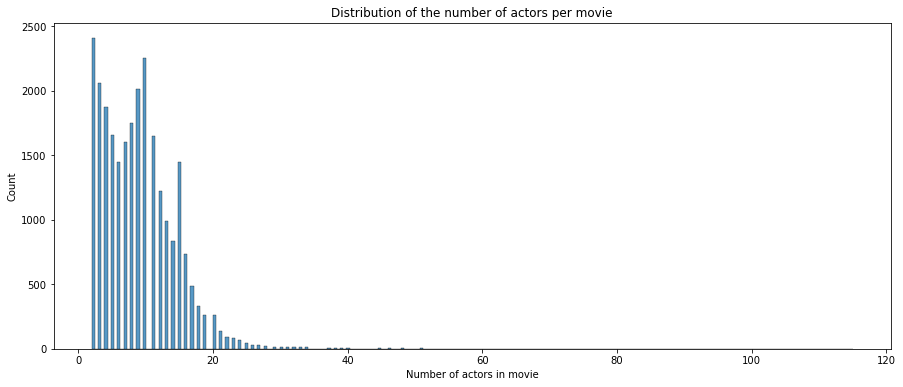

In average, there is 9.03 actors per movie among the american movies dataset with more than two actors.
There are 25938 unique movies which have a known list of actors greater than 2.


In [20]:
#nb actors per movie
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movies, x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors in movie")
plt.show()
avg_nb_actors_per_movie = df_movies['nb_actors'].mean()
nb_unique_movies_with_actors = df_movies['wikipedia_m_ID'].nunique()
print("In average, there is {:.2f} actors per movie among the american movies dataset with more than two actors.".format(avg_nb_actors_per_movie))
print("There are {} unique movies which have a known list of actors greater than 2.".format(nb_unique_movies_with_actors))

# 3.4 Number of movies of actor when releasing movie

In [21]:
#merge: if known score, column of score is = to score, otherwise = 0
df_chars_numbers = df_chars.merge(df_numbers, left_on='actor_name', right_index=True, how='left').copy()
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,11.0,12.0,12.0,13.0,14.0,14.0,14.0,14.0,14.0,14.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,9.0,10.0,11.0,11.0,12.0,13.0,14.0,14.0,15.0,15.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_numbers.reset_index()[df_numbers.reset_index()['actor_name']=='Alan Alda']

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
6,Alan Alda,227.0,317.0,317.0,317.0,317.0,317.0,317.0,317.0,317.0,...,1,1,1,1,1,1,1,1,1,1


In [23]:
map_nb_movies_per_year = df_chars_numbers.groupby(['m_release_date', 'actor_name'])['wikipedia_m_ID'].count().reset_index().copy()

In [24]:
map_nb_movies_per_year['m_release_year'] = map_nb_movies_per_year['m_release_date'].dt.year

In [25]:
map_nb_movies_per_year = map_nb_movies_per_year.groupby(['actor_name', 'm_release_year'])['wikipedia_m_ID'].count().reset_index()

In [26]:
map_nb_movies_per_year

,actor_name,m_release_year,wikipedia_m_ID
0,Daniel Newman,1998,1
1,'Big Bill' Giddinger,1911,1
2,'Big' Lee,1973,1
3,'Chicken' Holleman,1972,1
4,'Crazy George' Henderson,1975,1
...,...,...,...
182314,Željko Ivanek,2007,1
182315,Željko Ivanek,2008,1
182316,Željko Ivanek,2012,3
182317,“Lee” George Quinones,1982,1


In [27]:
nb_years = range(1980, 2013)
list_groups = dict()
for y in nb_years:
    filter_conditions=(
        map_nb_movies_per_year['m_release_year'] <= y
    )
    list_year = map_nb_movies_per_year[filter_conditions]
    list_groups.update({y: list_year.groupby('actor_name')['wikipedia_m_ID'].count()})

In [28]:
def get_nb_movies_each_year(row):
    release_year = row['m_release_date'].year
    actor_name = row['actor_name']
    try:
        nb_movies = list_groups[release_year][actor_name]
    except:
        nb_movies = 0
    return nb_movies

In [29]:
df_chars_numbers['nb_years_acting'] = df_chars_numbers.apply(lambda row: get_nb_movies_each_year(row), axis=1)

In [ ]:
def update_score(row, year):
    release_year = row['m_release_date'].year
    try:
        cnt = float(row[str(release_year)])
        return cnt / row['nb_years_acting']
    except:
        return 0

In [ ]:
for y in range(1980, 2023):
    df_chars_numbers[str(y)] = df_chars_numbers.apply(lambda row: update_score(row, y), axis=1)

In [ ]:
df_chars_numbers

# 3.5 Number of movies per decade

In [34]:
nb_decades_lower = range(1980, 2030, 10)
nb_decades_upper = range(1990, 2030, 10)
list_decades = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] >= dec_lower)&
        (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] =list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [35]:
for key, dec in list_decades.items():
    df_chars_numbers = df_chars_numbers.merge(dec, on='actor_name', how='left')
    df_chars_numbers['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [36]:
df_chars_numbers.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022,nb_years_acting,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,3,0.0,2.0,4.0,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,1.0,1.0,1.0,1.0,1.0,5,0.0,3.0,6.0,0.0


# 3.5 Compute scores per actor at movie time

In [37]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [38]:
nb_unique_movies = df_chars_numbers['wikipedia_m_ID'].nunique()
print("There are {} unique movies with coacting.".format(nb_unique_movies))

There are 14572 unique movies with coacting.


In [40]:
df_chars_numbers['nb_years_acting']

0         3
1         5
2         8
3         2
4         5
         ..
234265    2
234266    1
234267    1
234268    1
234269    1
Name: nb_years_acting, Length: 155179, dtype: int64

In [41]:
def get_movie_actor_score(row):
    release_date = row['m_release_date'].year
    val = row[str(release_date-1)]
    if val > 0:
        return val
    else:
        return 0

In [42]:
df_chars_numbers['actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

In [44]:
df_chars_numbers['actor_score_norm'] = df_chars_numbers['actor_score'] / df_chars_numbers['nb_years_acting']

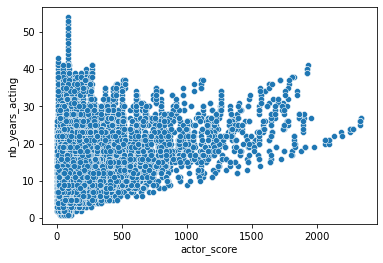

In [45]:
sns.scatterplot(data = df_chars_numbers[df_chars_numbers['actor_score']>0], y='nb_years_acting', x='actor_score');

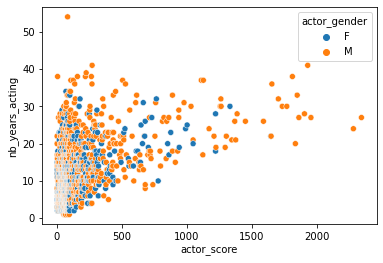

In [46]:
sns.scatterplot(data = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0)].sort_values('actor_score').drop_duplicates('actor_name', keep='last'), y='nb_years_acting', x='actor_score', hue="actor_gender");

In [47]:
women_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']
men_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_years_acting']

In [48]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had before performed 10.88 movies in average.
At the peak of their carreer, men had before performed 13.03 movies in average.


Ttest_indResult(statistic=-5.091150730397673, pvalue=4.0239015365219453e-07)

In [49]:
women_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [50]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their carreer, women have in average reached a score of 145.52.
At the peak of their carreer, men have in average reached a score of 196.49.


Ttest_indResult(statistic=-3.441395173090973, pvalue=0.000595110107824312)

# 3.6 Compute scores per movie

In [51]:
nb_unique_actors = df_chars_numbers['actor_name'].nunique()
print("There are {} unique actors with coacting.".format(nb_unique_actors))

There are 53669 unique actors with coacting.


In [52]:
df_chars_numbers.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022,nb_years_acting,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020,actor_score,actor_score_norm
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,3,0.0,2.0,4.0,0.0,0.0,0.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,1.0,1.0,1.0,5,0.0,3.0,6.0,0.0,57.0,11.4


In [53]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'nb_years_acting', 'actor_score', 'actor_score_norm']
df_temp = df_chars_numbers.copy()
df_temp['nb_years_acting'] = df_temp['nb_years_acting'].astype(str)
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_score_norm'] = df_temp['actor_score_norm'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_grouped = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join,'actor_gender':'$l$'.join, 'nb_years_acting':'$l$'.join, 'actor_score':'$l$'.join, 'actor_score_norm':'$l$'.join})

In [ ]:
df_grouped

In [54]:
def get_function_of_list_values(list_values, function, gender=None):
    list_split = list_values.split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [55]:
def get_function_of_list_values_condition(row, function, gender_cat=None):
    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    list_split = []
    for x, gender in zip(list_temp, gender_split):
        if gender == gender_cat:
            list_split.append(x)
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        try:
            return (np.count_nonzero(list_split))/np.count_nonzero(list_temp)
        except:
            return 0

In [56]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_grouped['score_'+f] = df_grouped['actor_score'].apply(lambda x: get_function_of_list_values(x, f))
    df_grouped['score_norm_'+f] = df_grouped['actor_score_norm'].apply(lambda x: get_function_of_list_values(x, f))

list_function_nb_movies = ['max', 'min', 'mean', 'median', 'nb_actors_already_played', 'prop_nb_movies']
for f in list_function_nb_movies:
    df_grouped['nb_movies_'+f] = df_grouped['nb_years_acting'].apply(lambda x: get_function_of_list_values(x, f))


In [57]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_grouped[gender+'_'+f] = df_grouped.apply(lambda row: get_function_of_list_values_condition(row, f, gender), axis=1)


<AxesSubplot:>

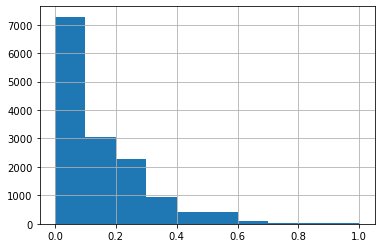

In [61]:
df_grouped['score_prop_famous_actors'].hist()

# 3.7 Merge score with actors

In [68]:
list_columns = ['score_'+x for x in list_function_score] + ['nb_movies_'+x for x in list_function_nb_movies] + ['F_'+x for x in list_function_score] + ['M_'+x for x in list_function_score]

In [69]:
df_chars_merged = df_chars_numbers.merge(df_grouped[list_columns], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,25.666667,23.0,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,25.666667,23.0,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,25.666667,23.0,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4


# 3.8 Number of actors revealed per movie

In [70]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4,0,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4,0,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4,0,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4,0,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,3.0,0.6,336.0,0.0,32.272727,0.0,2.0,0.4,0,0


# 4.1 Movies that have a revelation

In [71]:
df_movie_revelation = df_chars_merged.groupby('wikipedia_m_ID')['is_revealed'].sum().copy().reset_index()
df_movie_revelation.rename({'is_revealed' : 'has_revelation'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,has_revelation
0,3217,1
1,3746,1
2,3947,0
3,4231,0
4,4560,0


In [72]:
df_movie_revelation['has_revelation'].value_counts()

0    12836
1     1736
Name: has_revelation, dtype: int64

In [73]:
df_chars_revelation = df_chars_merged.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [74]:
df_revelation = df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')

In [75]:
df_revelation = df_revelation[df_revelation['score_nb_famous_actors'] > 0].copy()

In [76]:
df_revelation.groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,1.098992e+07,1.862451,40.122891,11.605198,16.876836,19.851977,24.285499,31.449718,36.565725,43.981544,...,0.799511,0.334499,249.162842,3.175145,47.482714,10.346281,1.564003,0.682526,0.0,0.286716
1,8.138680e+06,1.748792,32.160727,15.198223,0.000000,0.559809,1.311688,2.708134,4.634997,7.352700,...,0.980623,0.324256,351.940533,0.066986,51.762916,4.645249,2.062884,0.679733,1.0,0.000000


<AxesSubplot:xlabel='has_revelation', ylabel='score_prop_famous_actors'>

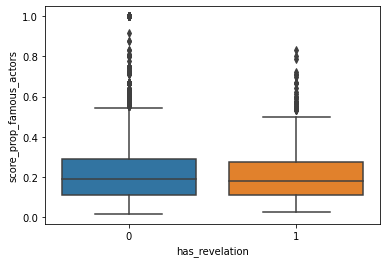

In [77]:
sns.boxplot(data=df_revelation, x='has_revelation',y='score_prop_famous_actors')

In [78]:
df_revelation.groupby('has_revelation')['M_prop_famous_actors'].mean()

has_revelation
0    0.682526
1    0.679733
Name: M_prop_famous_actors, dtype: float64

In [79]:
df_revelation.groupby('has_revelation')['F_prop_famous_actors'].mean()

has_revelation
0    0.334499
1    0.324256
Name: F_prop_famous_actors, dtype: float64

<AxesSubplot:xlabel='has_revelation', ylabel='M_prop_famous_actors'>

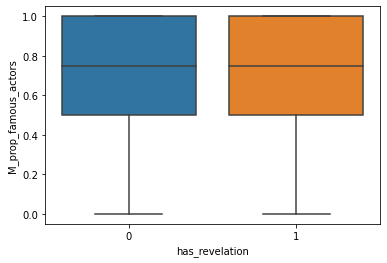

In [80]:
sns.boxplot(data=df_revelation, x='has_revelation',y='M_prop_famous_actors')

<AxesSubplot:xlabel='has_revelation', ylabel='F_prop_famous_actors'>

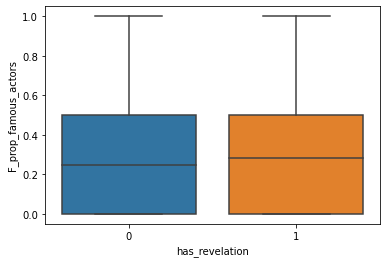

In [81]:
sns.boxplot(data=df_revelation, x='has_revelation',y='F_prop_famous_actors')

In [82]:
list_columns

['score_max',
 'score_min',
 'score_mean',
 'score_median',
 'score_nb_famous_actors',
 'score_prop_famous_actors',
 'nb_movies_max',
 'nb_movies_min',
 'nb_movies_mean',
 'nb_movies_median',
 'nb_movies_nb_actors_already_played',
 'nb_movies_prop_nb_movies',
 'F_max',
 'F_min',
 'F_mean',
 'F_median',
 'F_nb_famous_actors',
 'F_prop_famous_actors',
 'M_max',
 'M_min',
 'M_mean',
 'M_median',
 'M_nb_famous_actors',
 'M_prop_famous_actors']

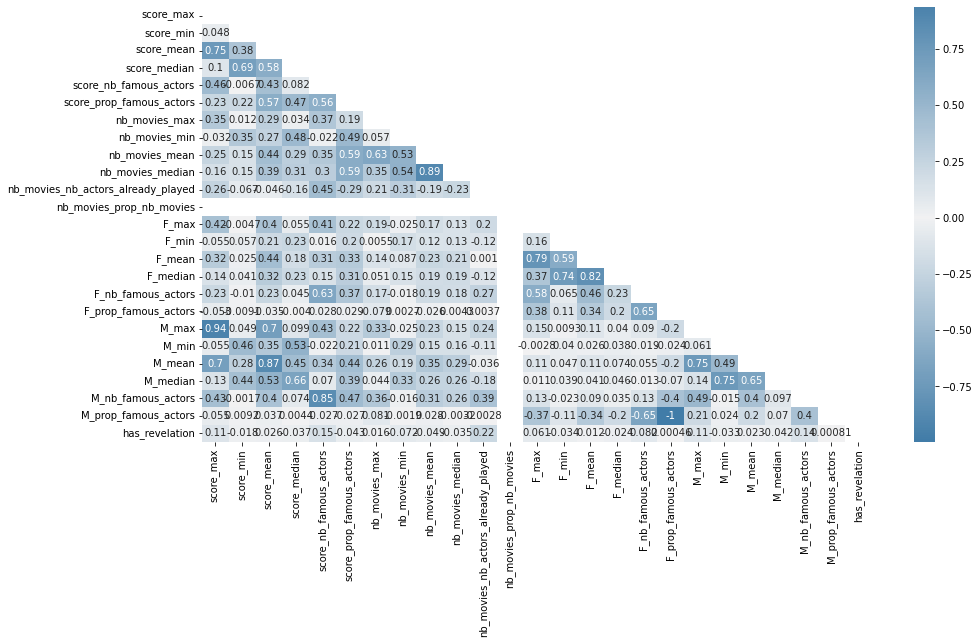

In [83]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'has_revelation']
dataset = df_revelation[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [84]:
X = dataset.drop('has_revelation', axis=1)
y = dataset['has_revelation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 65.05%


In [85]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.67      0.89      0.77      1644
         1.0       0.59      0.27      0.37       977

    accuracy                           0.66      2621
   macro avg       0.63      0.58      0.57      2621
weighted avg       0.64      0.66      0.62      2621



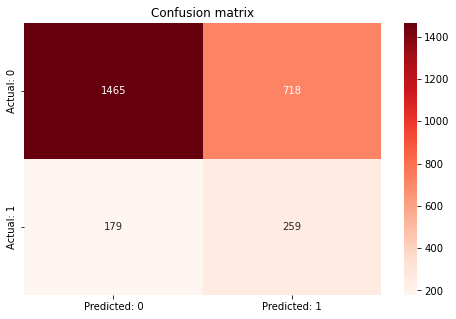

In [86]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

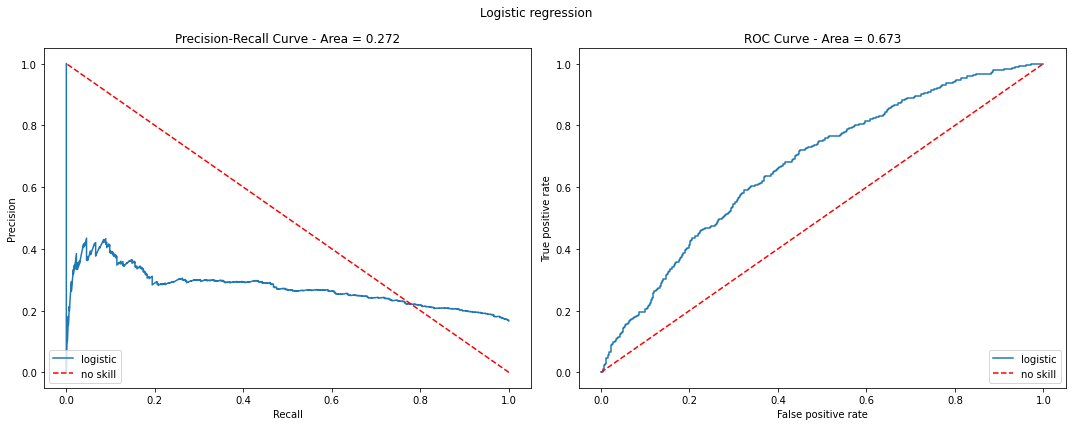

In [87]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

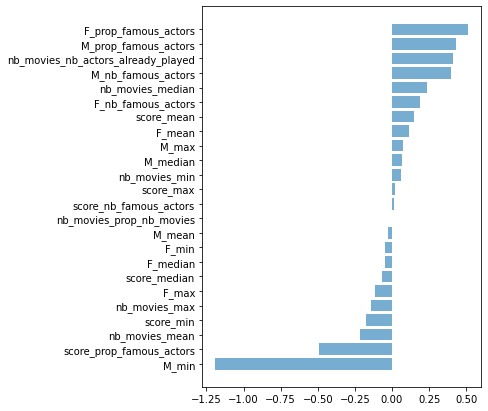

In [88]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 5.1 Carreer booster

In [89]:
df_movie_revelation = df_chars_revelation[df_chars_revelation['has_revelation'] > 0].copy()
df_movie_revelation.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation
8732,36229546,/m/0gx8qlq,2012-01-20,Jesse,1978-08-18,M,1.77,Jewish people,Andy Samberg,33.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,1,0,1
8727,36229546,/m/0gx8qlq,2012-01-20,NaN,1971-11-09,M,NaN,NaN,Jason Antoon,40.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,0,1
8728,36229546,/m/0gx8qlq,2012-01-20,Scott,1981-01-28,M,1.68,English American,Elijah Wood,30.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
8729,36229546,/m/0gx8qlq,2012-01-20,Riley,1991-02-10,F,1.60,NaN,Emma Roberts,20.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
8730,36229546,/m/0gx8qlq,2012-01-20,Celeste,1976-02-25,F,1.63,African Americans,Rashida Jones,35.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,0,1


In [90]:
df_chars_already_revealed = df_movie_revelation[df_movie_revelation['already_revealed'] == 1].copy()
df_chars_already_revealed.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation
8728,36229546,/m/0gx8qlq,2012-01-20,Scott,1981-01-28,M,1.68,English American,Elijah Wood,30.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
8729,36229546,/m/0gx8qlq,2012-01-20,Riley,1991-02-10,F,1.60,NaN,Emma Roberts,20.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
8733,36229546,/m/0gx8qlq,2012-01-20,Tucker,1977-05-31,M,1.88,white Americans,Eric Christian Olsen,34.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
8734,36229546,/m/0gx8qlq,2012-01-20,Paul,1974-08-11,M,1.75,NaN,Chris Messina,37.0,...,0.25,286.0,0.0,30.727273,0.0,3.0,0.75,0,1,1
130301,35589999,/m/0gxmvbv,2012-09-01,Susanna,1960-12-03,F,1.60,Scottish American,Julianne Moore,NaN,...,0.50,91.0,0.0,45.500000,45.5,1.0,0.50,0,1,1


In [91]:
df_tmp = df_chars_already_revealed.groupby('actor_name')['already_revealed'].sum().reset_index().sort_values('already_revealed', ascending=False).copy()
df_tmp.rename({'already_revealed':'nb_movies_when_revelation'}, axis=1, inplace=True)

In [92]:
df_nb_movies_carreer_booster = df_chars_revelation[df_chars_revelation['already_revealed'] == 1].groupby('actor_name')['wikipedia_m_ID'].count().reset_index().sort_values('wikipedia_m_ID', ascending=False).copy()
df_nb_movies_carreer_booster.rename({'wikipedia_m_ID': 'nb_movies'}, axis=1, inplace=True)

In [93]:
df_carreer_booster = df_nb_movies_carreer_booster.merge(df_tmp, on='actor_name', how='left').copy()
df_carreer_booster['nb_movies_when_revelation'] = df_carreer_booster['nb_movies_when_revelation'].fillna(0)
df_carreer_booster['ratio_movies_when_revelation'] = df_carreer_booster.apply(lambda row: row['nb_movies_when_revelation']*row['nb_movies_when_revelation'] / row['nb_movies'], axis=1)

In [94]:
df_carreer_booster.sort_values(['nb_movies_when_revelation', 'ratio_movies_when_revelation'], ascending=False).head(22)

,actor_name,nb_movies,nb_movies_when_revelation,ratio_movies_when_revelation
2,Bruce Willis,71,24.0,8.112676
28,Ben Stiller,51,21.0,8.647059
6,Robert De Niro,63,20.0,6.349206
4,John Goodman,64,20.0,6.250000
17,Dan Aykroyd,54,18.0,6.000000
1,Samuel L. Jackson,73,18.0,4.438356
36,Matt Damon,48,17.0,6.020833
13,Dennis Quaid,56,17.0,5.160714
137,Ben Affleck,34,16.0,7.529412
59,Bill Murray,43,16.0,5.953488


# 6.1 Stay in the loop

In [95]:
df_numbers_yearly.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
0,Jane Fonda,440.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,...,4,5,5,5,5,6,6,6,6,6
1,Clint Eastwood,360.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,...,19,19,19,19,19,20,20,20,21,21


In [105]:
columns = df_numbers_yearly.columns[1:]

In [115]:
df_loop = df_chars_merged.loc[(df_chars_merged['already_revealed']==1) & (df_chars_merged['nb_years_acting']>=1)].sort_values(['actor_name', 'm_release_date']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.drop(columns, axis=1, inplace=True)
df_loop = df_loop.merge(df_numbers_yearly, on='actor_name', how='left').copy()
df_loop.dropna(subset=['actor_gender'], inplace=True)
df_loop.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,nb_ranked_2013,nb_ranked_2014,nb_ranked_2015,nb_ranked_2016,nb_ranked_2017,nb_ranked_2018,nb_ranked_2019,nb_ranked_2020,nb_ranked_2021,nb_ranked_2022
0,9088886,/m/027x7z5,2002-01-10,Queen Akasha,1979-01-16,F,1.65,African Americans,Aaliyah,22.0,...,2,2,2,2,2,2,2,2,2,2
1,939561,/m/03rvz7,2004-08-27,Thomas Mackelway,1968-03-12,M,1.83,NaN,Aaron Eckhart,36.0,...,4,4,4,5,5,5,6,6,6,6
2,17922358,/m/047rcns,2009-01-01,NaN,1979-05-12,M,1.71,NaN,Aaron Yoo,29.0,...,1,1,1,1,1,1,1,1,1,1
3,33757147,/m/0gxtknx,2012-09-07,Kaya,1982-08-07,F,1.73,Australians,Abbie Cornish,30.0,...,1,1,1,1,1,1,1,1,1,1
4,10746393,/m/02qnxd8,2007-07-25,Zoe,1996-04-14,F,1.54,NaN,Abigail Breslin,11.0,...,5,5,5,5,5,5,6,6,7,7


In [116]:
df_loop['actor_gender'].value_counts()

M    903
F    554
Name: actor_gender, dtype: int64

In [117]:
def get_score_year(row):
    release_year = row['m_release_date'].year
    return int(row['{}'.format(release_year)] > 0)

In [118]:
df_loop['still_ranked'] = df_loop.apply(lambda row: get_score_year(row), axis=1)

In [119]:
df_loop['is_main_actor'] = (df_loop['score_max'] == df_loop['min_year_score']).astype(int)

In [120]:
df_loop['is_main_actor'].sum()

395

In [121]:
df_loop['still_ranked'].sum()

303

In [122]:
df_loop[df_loop['still_ranked'] == 1]['is_main_actor'].sum()

73

In [123]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 0)].shape

(832, 137)

In [124]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 0)].shape

(322, 137)

In [125]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 1)].shape

(73, 137)

In [126]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 1)].shape

(230, 137)

In [127]:
#df_loop.drop_duplicates('wikipedia_m_ID', keep='first', inplace=True)

In [128]:
df_loop['wikipedia_m_ID'].nunique()

1299

In [129]:
df_loop.groupby('still_ranked')[list_columns+['is_main_actor']].mean()

,score_max,score_min,score_mean,score_median,score_nb_famous_actors,score_prop_famous_actors,nb_movies_max,nb_movies_min,nb_movies_mean,nb_movies_median,...,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_main_actor
still_ranked,,,,,,,,,,,,,,,,,,,,,
0,260.205373,0.165511,34.710610,3.422010,3.110052,0.254453,18.038995,1.383882,6.456451,4.922877,...,14.497768,1.101786,0.359613,223.405570,1.738033,39.525734,8.436031,2.049608,0.653815,0.279029
1,321.600660,0.000000,42.535851,5.234323,3.801980,0.264401,18.178218,1.356436,6.346373,4.861386,...,19.031561,1.209302,0.320738,290.099338,1.182119,49.246515,9.849338,2.602649,0.681980,0.240924


In [130]:
df_loop[df_loop['actor_gender']=='M'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

,score_max,score_min,score_mean,score_median,score_nb_famous_actors,score_prop_famous_actors,nb_movies_max,nb_movies_min,nb_movies_mean,nb_movies_median,...,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_main_actor
still_ranked,,,,,,,,,,,,,,,,,,,,,
0,270.285513,0.032349,35.311837,3.206048,3.149086,0.250767,18.091421,1.348805,6.427042,4.873418,...,12.238552,0.763663,0.185452,238.533052,1.315049,41.839932,9.815752,2.421941,0.823417,0.278481
1,304.052083,0.000000,38.419455,5.611979,3.630208,0.245242,17.567708,1.302083,6.032209,4.531250,...,16.171053,0.826316,0.191109,277.135417,0.989583,45.570579,10.682292,2.807292,0.809580,0.250000


In [131]:
df_loop[df_loop['actor_gender']=='F'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

,score_max,score_min,score_mean,score_median,score_nb_famous_actors,score_prop_famous_actors,nb_movies_max,nb_movies_min,nb_movies_mean,nb_movies_median,...,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_main_actor
still_ranked,,,,,,,,,,,,,,,,,,,,,
0,244.027088,0.379233,33.745661,3.768623,3.047404,0.260369,17.954853,1.440181,6.503653,5.002257,...,17.950339,1.618510,0.625769,198.849315,2.424658,35.769123,6.196347,1.445205,0.378503,0.279910
1,351.954955,0.000000,49.656105,4.581081,4.099099,0.297542,19.234234,1.450450,6.889792,5.432432,...,23.927928,1.864865,0.542626,312.727273,1.518182,55.662696,8.395455,2.245455,0.459259,0.225225


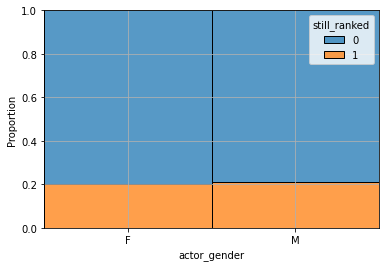

In [132]:
sns.histplot(data=df_loop,x='actor_gender',hue='still_ranked', cumulative=False, multiple='fill', stat='proportion')
plt.grid();

<AxesSubplot:xlabel='actor_gender', ylabel='score_max'>

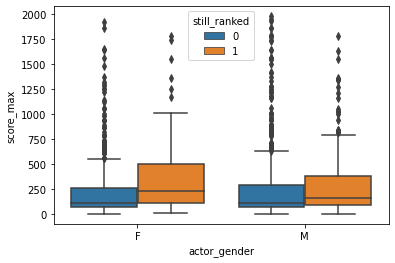

In [133]:
sns.boxplot(data=df_loop,x='actor_gender',y='score_max', hue='still_ranked')

<AxesSubplot:xlabel='actor_gender', ylabel='F_max'>

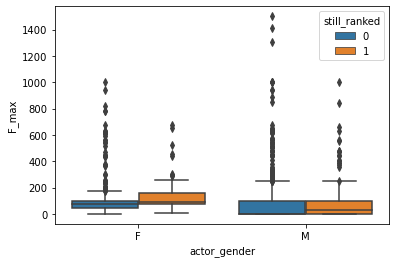

In [134]:
sns.boxplot(data=df_loop,x='actor_gender',y='F_max', hue='still_ranked')

<AxesSubplot:xlabel='actor_gender', ylabel='M_max'>

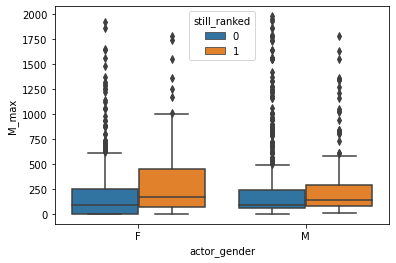

In [135]:
sns.boxplot(data=df_loop,x='actor_gender',y='M_max', hue='still_ranked')

In [136]:
df_tmp = df_loop.dropna()
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['M_max'], df_tmp[df_tmp['still_ranked']==0]['M_max'])

Ttest_indResult(statistic=1.9426933836171543, pvalue=0.05251001051348918)

In [137]:
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['F_max'], df_tmp[df_tmp['still_ranked']==0]['F_max'])

Ttest_indResult(statistic=-0.6049568040632163, pvalue=0.5454312031073614)

# 6.2 Correlation

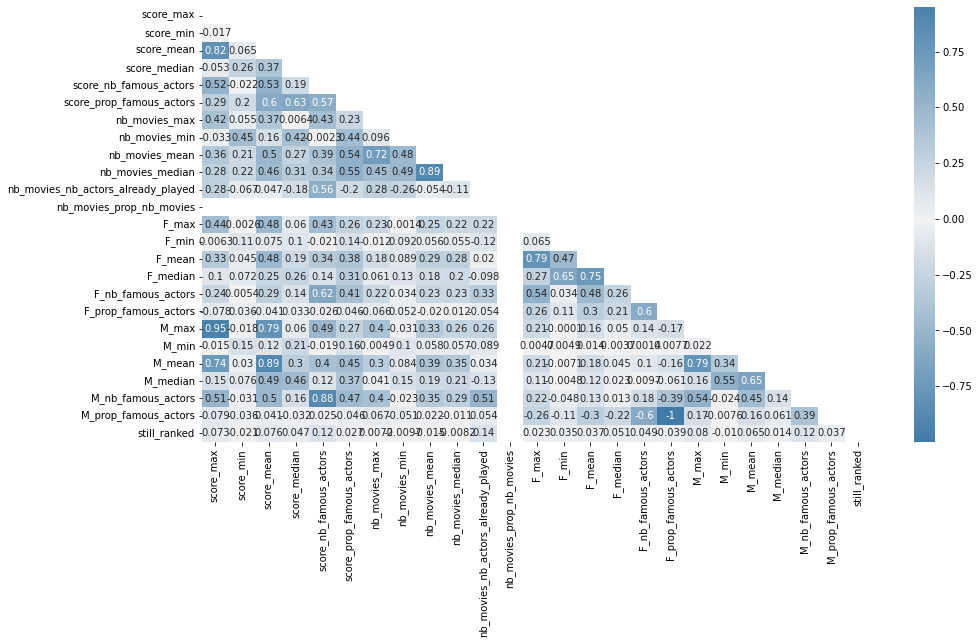

In [138]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'still_ranked']
dataset = df_loop[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [139]:
X = dataset.drop('still_ranked', axis=1)
y = dataset['still_ranked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='lbfgs', max_iter=10000,penalty='l2', C=0.2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 65.16%


In [140]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.79      0.70       270
         1.0       0.44      0.26      0.33       168

    accuracy                           0.59       438
   macro avg       0.54      0.53      0.52       438
weighted avg       0.56      0.59      0.56       438



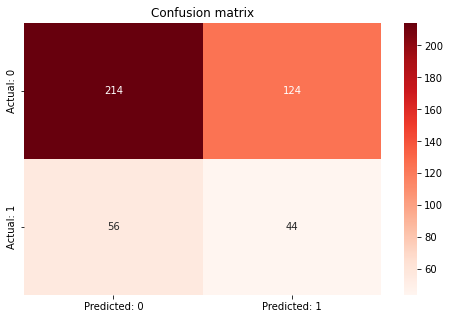

In [141]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

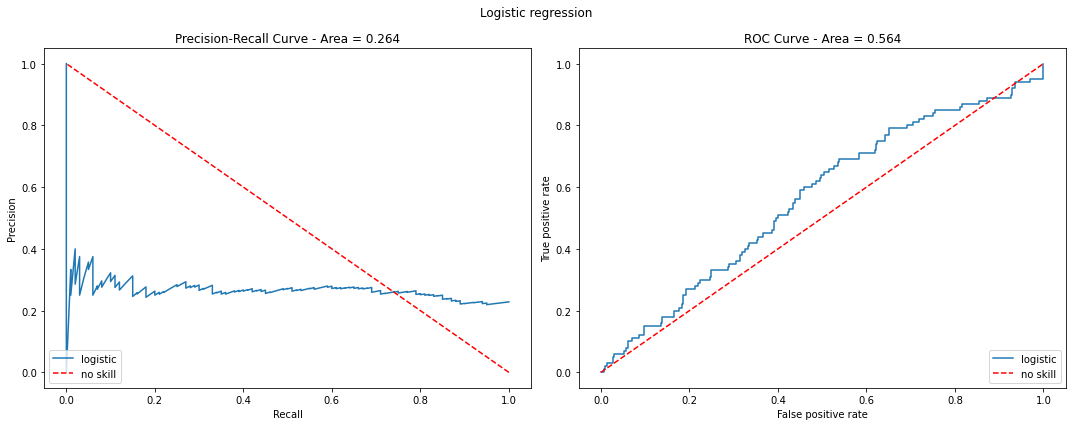

In [142]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

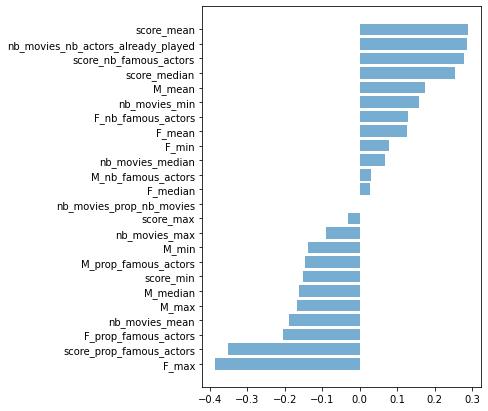

In [143]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 7 Analysis by decade

In [144]:
df_revelation['m_release_dec'] = df_revelation['m_release_date'].apply(lambda x: x.year//10*10)

In [145]:
df_revelation.groupby(['m_release_dec', 'has_revelation']).mean()

wikipedia_m_ID  actor_height  actor_age  \
m_release_dec has_revelation                                            
1980          0                 8.842139e+06      1.757691  39.876147   
              1                 3.828441e+06      1.749619  31.768473   
1990          0                 8.306251e+06      1.764502  39.954047   
              1                 3.866047e+06      1.750004  34.009615   
2000          0                 9.806682e+06      1.976711  40.093728   
              1                 6.389476e+06      1.748317  31.424144   
2010          0                 2.735812e+07      1.758558  41.173693   
              1                 2.639826e+07      1.746767  30.964824   

                              nb_actors       1980       1981       1982  \
m_release_dec has_revelation                                               
1980          0               10.127510  44.313351  52.776567  60.411444   
              1               12.815166   0.000000   3.881517   9.094787   
1990          0               10.737132  18.218245  21.446882  27.348730   
              1               14.166271   0.000000   0.000000   0.000000   
2000          0               12.143069   9.120346  10.461472  13.128139   
              1               16.446228   0.000000   0.000000   0.000000   
2010          0               13.723666   8.367041  10.044944  12.958801   
              1               15.966346   0.000000   0.000000   0.000000   

                                   1983       1984       1985  ...  \
m_release_dec has_revelation                                   ...   
1980          0               72.013624  81.901907  99.782016  ...   
              1               18.777251  32.137441  50.981043  ...   
1990          0               35.653580  42.558891  51.473441  ...   
              1                0.000000   0.000000   0.000000  ...   
2000          0               18.759307  21.535931  25.397403  ...   
              1                0.000000   0.000000   0.000000  ...   
2010          0               16.955056  19.827715  23.374532  ...   
              1                0.000000   0.000000   0.000000  ...   

                              F_nb_famous_actors  F_prop_famous_actors  \
m_release_dec has_revelation                                             
1980          0                         0.544681              0.305064   
              1                         0.567961              0.295731   
1990          0                         0.709476              0.314083   
              1                         0.844125              0.328978   
2000          0                         0.878403              0.351208   
              1                         1.095779              0.334250   
2010          0                         1.044160              0.357448   
              1                         1.325243              0.313340   

                                   M_max     M_min     M_mean   M_median  \
m_release_dec has_revelation                                               
1980          0               139.910192  2.182644  30.247196   8.080727   
              1               161.056872  0.000000  28.638800   3.457346   
1990          0               233.431472  2.767420  45.573427  10.694970   
              1               296.831354  0.000000  45.562277   2.634204   
2000          0               267.780765  2.764636  49.396510   9.181004   
              1               397.454254  0.011236  54.969568   5.235152   
2010          0               359.089286  7.627747  67.826721  17.751374   
              1               520.798077  0.437500  78.166344   8.153846   

                              M_nb_famous_actors  M_prop_famous_actors  \
m_release_dec has_revelation                                             
1980          0                         1.158426              0.714083   
              1                         1.393365              0.711277   
1990          0                        

<AxesSubplot:xlabel='m_release_dec', ylabel='nb_actors'>

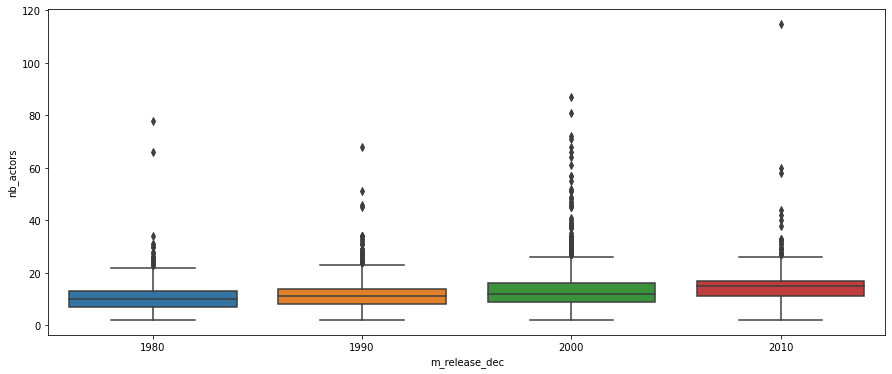

In [146]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='nb_actors')

<AxesSubplot:xlabel='m_release_dec', ylabel='score_prop_famous_actors'>

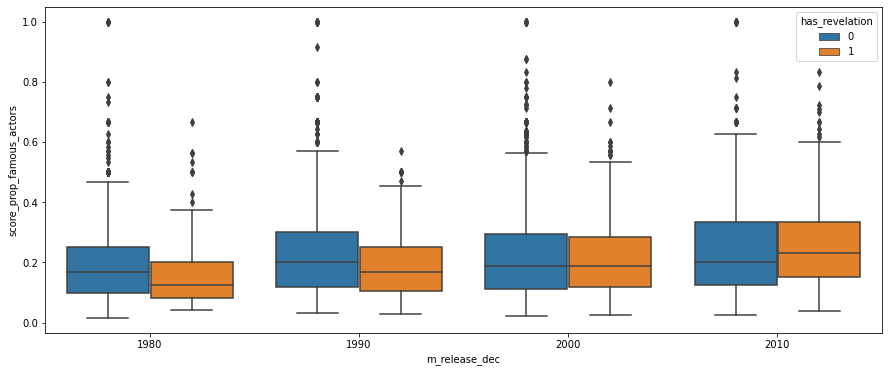

In [147]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_prop_famous_actors', hue='has_revelation')

In [148]:
df_revelation[df_revelation['m_release_dec'] >= 2010]

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation,m_release_dec
67879,36598025,/m/0gwvbxv,2012-10-18,Kim,1972-12-07,F,1.730,NaN,Christa Campbell,39.0,...,1907.0,0.0,547.142857,0.0,3.0,0.428571,0,0,0,2010
122006,36563324,/m/0h2_8ts,2011-01-01,Jill Richardson,NaN,F,NaN,NaN,Nancy Karr,NaN,...,253.0,0.0,32.100000,0.0,2.0,1.000000,0,0,0,2010
25592,36500436,/m/0h0zb36,2012-09-07,Pavel,NaN,M,NaN,NaN,Andrey Kaykov,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,2010
111216,36500393,/m/0gy74js,2012-01-27,Nurse Mike,1974-02-26,M,NaN,NaN,Jayce Bartok,37.0,...,143.0,0.0,20.363636,0.0,2.0,1.000000,0,0,0,2010
75790,36478252,/m/0cnm1t2,2010-06-10,Ormsby,1948-05-12,M,1.750,NaN,Richard Riehle,62.0,...,95.0,0.0,10.555556,0.0,1.0,0.500000,0,0,0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61886,2549266,/m/087vnr5,2010-08-02,Hal,1976-10-06,M,NaN,NaN,Brett Gelman,33.0,...,824.0,0.0,145.055556,0.0,5.0,0.714286,0,0,0,2010
113865,1213838,/m/04hwbq,2010-06-12,Ken,1951-09-05,M,1.780,Scottish American,Michael Keaton,58.0,...,2334.0,0.0,218.875000,0.0,4.0,0.571429,0,1,0,2010
55414,982480,/m/03whyr,2012-03-08,Powell,1956-03-07,M,1.791,NaN,Bryan Cranston,56.0,...,254.0,0.0,56.900000,0.0,3.0,1.000000,1,0,1,2010
150401,619728,/m/02xbyr,2010-11-24,Guard #1,NaN,M,NaN,NaN,Nathan Greno,NaN,...,111.0,0.0,9.250000,0.0,1.0,0.333333,0,0,0,2010


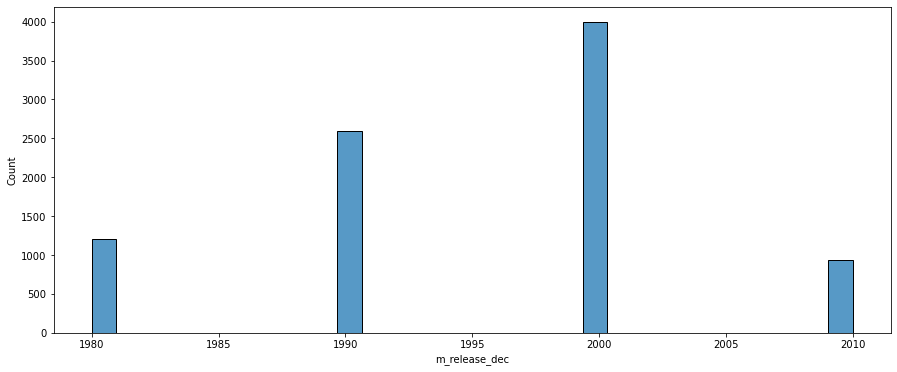

In [149]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_revelation, x='m_release_dec');

<AxesSubplot:xlabel='m_release_dec', ylabel='score_mean'>

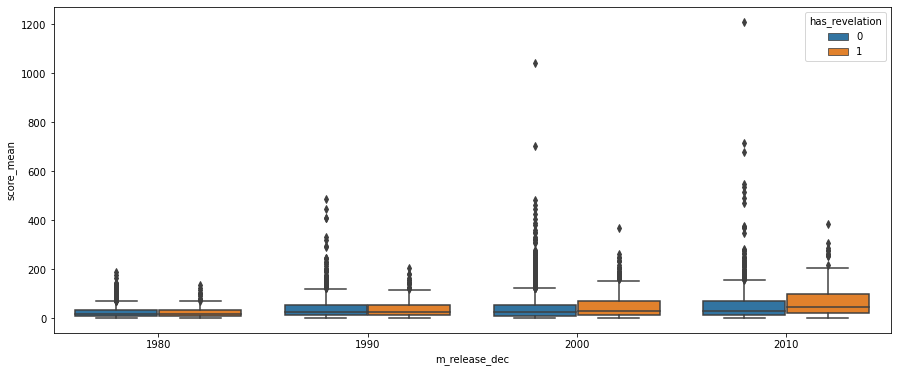

In [150]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_revelation, x='m_release_dec', y='score_mean', hue='has_revelation')

In [151]:
df_revelation.columns

Index(['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date', 'character_name',
       'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity',
       'actor_name', 'actor_age',
       ...
       'M_max', 'M_min', 'M_mean', 'M_median', 'M_nb_famous_actors',
       'M_prop_famous_actors', 'is_revealed', 'already_revealed',
       'has_revelation', 'm_release_dec'],
      dtype='object', length=137)

In [152]:
for dec in df_revelation['m_release_dec'].sort_values().unique():
    df_tmp = df_revelation[df_revelation['m_release_dec'] == dec]
    

In [153]:
df_revelation[df_revelation['nb_movies_dec_1990_2000'] >0]

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,has_revelation,m_release_dec
23371,37373877,/m/02vr316,2006-10-31,Beth Patterson,1970-02-04,F,1.600,British Indian people,Gabrielle Anwar,36.0,...,7.0,0.0,2.333333,0.0,1.0,0.500000,0,0,0,2000
111216,36500393,/m/0gy74js,2012-01-27,Nurse Mike,1974-02-26,M,NaN,NaN,Jayce Bartok,37.0,...,143.0,0.0,20.363636,0.0,2.0,1.000000,0,0,0,2010
75790,36478252,/m/0cnm1t2,2010-06-10,Ormsby,1948-05-12,M,1.750,NaN,Richard Riehle,62.0,...,95.0,0.0,10.555556,0.0,1.0,0.500000,0,0,0,2010
149227,36459873,/m/0k8s6n5,2012-07-15,NaN,1950-04-13,M,1.850,Jewish people,Ron Perlman,62.0,...,111.0,40.0,75.500000,75.5,2.0,1.000000,0,1,0,2010
38383,36445964,/m/0k9f3n9,1996-04-30,NaN,1957-01-28,M,1.750,NaN,Harley Jane Kozak,39.0,...,52.0,46.0,49.000000,49.0,2.0,1.000000,0,1,0,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100660,4728,/m/01hq1,1992-06-16,Ice Princess,1964-08-14,F,NaN,NaN,Cristi Conaway,27.0,...,154.0,0.0,42.571429,0.0,2.0,0.666667,0,0,0,1990
130089,4726,/m/01hp5,1989-06-19,Joker,1937-04-22,M,1.770,Italian Americans,Jack Nicholson,52.0,...,351.0,0.0,44.200000,0.0,2.0,0.666667,0,1,0,1980
77001,4560,/m/01gc7,1995-05-18,Morrison,1965-07-03,M,1.830,Scottish people,Tommy Flanagan,29.0,...,945.0,0.0,72.692308,0.0,1.0,1.000000,0,0,0,1990
99579,4231,/m/01cbx,1992-07-31,Buffy Summers,1969-12-19,F,1.676,Swedish Americans,Kristy Swanson,22.0,...,179.0,0.0,31.500000,0.0,3.0,1.000000,0,0,0,1990


In [154]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2010) & (df_revelation['m_release_date'].dt.year < 2020)].groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,m_release_dec
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,2.735812e+07,1.758558,41.173693,13.723666,8.367041,10.044944,12.958801,16.955056,19.827715,23.374532,...,0.357448,359.089286,7.627747,67.826721,17.751374,2.000000,0.659439,0.0,0.307798,2010.0
1,2.639826e+07,1.746767,30.964824,15.966346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.313340,520.798077,0.437500,78.166344,8.153846,2.730769,0.689673,1.0,0.000000,2010.0


In [155]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 2000) & (df_revelation['m_release_date'].dt.year < 2010)].groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,m_release_dec
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,9.806682e+06,1.976711,40.093728,12.143069,9.120346,10.461472,13.128139,18.759307,21.535931,25.397403,...,0.351208,267.780765,2.764636,49.396510,9.181004,1.645759,0.666336,0.0,0.274265,2000.0
1,6.389476e+06,1.748317,31.424144,16.446228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.334250,397.454254,0.011236,54.969568,5.235152,2.285714,0.669506,1.0,0.000000,2000.0


In [156]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year >= 1990) & (df_revelation['m_release_date'].dt.year < 2000)].groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,m_release_dec
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,8.306251e+06,1.764502,39.954047,10.737132,18.218245,21.446882,27.34873,35.65358,42.558891,51.473441,...,0.314083,233.431472,2.76742,45.573427,10.694970,1.476696,0.700864,0.0,0.306066,1990.0
1,3.866047e+06,1.750004,34.009615,14.166271,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.328978,296.831354,0.00000,45.562277,2.634204,1.738717,0.674148,1.0,0.000000,1990.0


In [157]:
df_revelation.loc[(df_revelation['m_release_date'].dt.year < 1990)].groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,nb_actors,1980,1981,1982,1983,1984,1985,...,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,m_release_dec
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,8.842139e+06,1.757691,39.876147,10.127510,44.313351,52.776567,60.411444,72.013624,81.901907,99.782016,...,0.305064,139.910192,2.182644,30.247196,8.080727,1.158426,0.714083,0.0,0.271084,1980.0
1,3.828441e+06,1.749619,31.768473,12.815166,0.000000,3.881517,9.094787,18.777251,32.137441,50.981043,...,0.295731,161.056872,0.000000,28.638800,3.457346,1.393365,0.711277,1.0,0.000000,1980.0
